ERROR! Session/line number was not unique in database. History logging moved to new session 274
Results for GPR with Kernel RBF(length_scale=1):
{'Kernel': RBF(length_scale=1), 'Train R2': 0.9184462298157763, 'Train RMSE': 0.28652152041475276, 'Train MSE': 0.0820945816607816, 'Train MAE': 0.20460217562695943, 'Test R2': 0.9027748479361788, 'Test RMSE': 0.3093875885834489, 'Test MSE': 0.09572067996948144, 'Test MAE': 0.22320932126612103, 'Train Size': 5600, 'Test Size': 2400}

Best Kernel: RBF(length_scale=1)


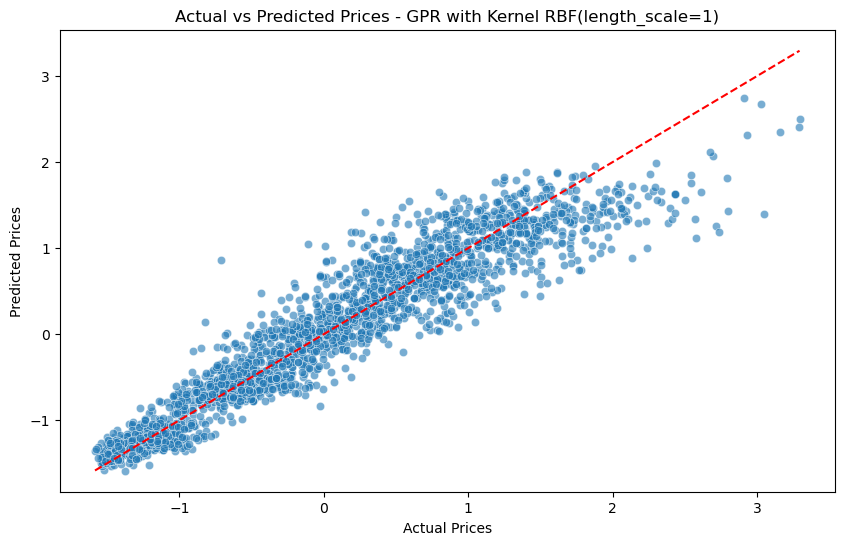

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./expedia_clean_df_normalized_with_features_engineering_25_06.csv')
df2 = pd.read_csv('./expedia_clean_df_normalized_with_features_engineering_20_06.csv')
df3 = pd.read_csv('./expedia_clean_df_normalized_with_features_engineering_05_07.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Subsample the data
df_subsampled = df.sample(n=8000, random_state=42)  # Reduced sample size

# Function to run GPR and calculate metrics
def run_gpr(df):

    columns_to_use = ['TTT', 'LOS', 'score', 'reviews', 'full_price',
                      'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
                      'star_rating', 'location_rating', 'km_from_center'] + \
                     [col for col in df.columns if df[col].isin([0, 1]).all()]

    df = df[columns_to_use]

    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')

    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Normalize the specified columns
    columns_to_normalize = ['star_rating', 'reviews', 'score', 'full_price', 'TTT', 'LOS']
    scaler = StandardScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    
    # Split the data into features (X) and target (y)
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize kernels
    kernels = [
        RBF(length_scale=1.0)
    ]
    
    results = []
    
    for kernel in kernels:
        # Initialize Gaussian Process Regressor with increased alpha
        model = GaussianProcessRegressor(kernel=kernel, alpha=1e-1, random_state=42)
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Training metrics
        train_r2 = r2_score(y_train, y_train_pred)
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        
        # Test metrics
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        results.append({
            'Kernel': kernel,
            'Train R2': train_r2,
            'Train RMSE': train_rmse,
            'Train MSE': train_mse,
            'Train MAE': train_mae,
            'Test R2': test_r2,
            'Test RMSE': test_rmse,
            'Test MSE': test_mse,
            'Test MAE': test_mae,
            'Train Size': len(X_train),
            'Test Size': len(X_test)
        })
        
    return results, y_test, y_test_pred

# Run GPR
results, y_test, y_test_pred = run_gpr(df_subsampled)

# Display results
for res in results:
    print(f"Results for GPR with Kernel {res['Kernel']}:")
    print(res)

# Plot actual vs predicted prices for the best performing kernel (highest Test R2)
best_result = max(results, key=lambda x: x['Test R2'])
print(f"\nBest Kernel: {best_result['Kernel']}")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Actual vs Predicted Prices - GPR with Kernel {best_result["Kernel"]}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()
